In [1]:
# Uncomment the following lines if running for the first time:
# !pip install datasets
# !pip install matplotlib
# !pip install tabulate
# !pip install scipy
# !pip install ipywidgets

In [ ]:
# Essential Imports for Telemetry Data Analysis and Visualization
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
from scipy.stats import skew
import seaborn as sns

## Preprocessing

The following code snippet uses the Hugging Face `datasets` library to load the **Intel CPU Telemetry Dataset** and save it as a CSV file for local analysis.


In [3]:
# Automatically download and save the dataset as CSV 
# only if "intel_cpu_dataset.csv" does not already exist.
# This avoids redundant downloads and ensures reproducibility.
if not os.path.exists("intel_cpu_dataset.csv"):
    from datasets import load_dataset
    ds = load_dataset("MounikaV/intel-cpu-dataset")
    ds["train"].to_pandas().to_csv("intel_cpu_dataset.csv", index=False)


In [4]:
# Load the Intel CPU dataset from CSV
df = pd.read_csv("intel_cpu_dataset.csv")

# Print the shape of the dataset (rows, columns)
print(df.shape)

# Print the list of column names
print(df.columns) 

(2081, 12)
Index(['vm_id', 'timestamp', 'cpu_usage', 'memory_usage', 'network_traffic',
       'power_consumption', 'num_executed_instructions', 'execution_time',
       'energy_efficiency', 'task_type', 'task_priority', 'task_status'],
      dtype='object')


### Observation
- From the above we know that:
  - There are 12 columns (vm_id timestamp cpu_usage memory_usage network_traffic power_consumption num_executed_instructions execution_time energy_efficiency task_type task_priority task_status) 
  - There are 2081 rows

In [5]:
# Preview the first 5 rows of the dataset
df.head(10)

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,1/25/2023 9:10,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,1/26/2023 4:46,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,1/13/2023 23:39,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2/9/2023 11:45,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,6/14/2023 8:27,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting
5,ad14d5d1-4e96-48ca-9893-1baaa47e4cab,2/6/2023 16:44,64.589411,62.008016,580.569836,115.931610,4766.0,63.137671,NaN,io,low,completed
6,5651505d-14a2-41d6-989b-eec0aac9b922,6/15/2023 18:04,43.758721,22.456429,429.139640,272.960417,9008.0,60.153904,0.461246,compute,high,completed
7,e5970e5c-0350-4131-bd6c-4bd7e2c98df1,NaN,NaN,85.438155,685.282813,NaN,NaN,14.191356,0.242538,network,high,running
8,7fc95f4c-f561-4dd5-8465-aec2b388bd5b,5/20/2023 19:09,96.366276,4.388441,902.827717,367.979056,9984.0,21.876694,NaN,io,medium,running
9,7fd9a664-1da8-4ae9-8a04-3c341d32d35c,7/10/2023 11:32,38.344152,16.441881,779.791345,382.756696,2989.0,42.160847,0.139187,io,medium,running


### Observation
- From the above we know that 
  - There are some missing data in some columns. Further action needed to be taken
  - Although most of the features are numeric, there are some columns (task_type,	task_priority,	task_status) are non-numeric.
  - Based on the `task_type` column, which contains categorical values such as `network`, `io`, and `compute`, I classify this feature as nominal since the categories represent distinct types without any inherent order.
  - The `task_priority` column contains categorical values such as `high`, `medium`, and `low`, which have a clear inherent order. Therefore, I classify this feature as ordinal.
  - Similarly, the `task_status` column includes categorical values like `waiting`, `running`, and `completed`, which suggest a natural progression. Hence, I classify this feature as ordinal.


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   vm_id                      1865 non-null   object 
 1   timestamp                  1886 non-null   object 
 2   cpu_usage                  1877 non-null   float64
 3   memory_usage               1865 non-null   float64
 4   network_traffic            1862 non-null   float64
 5   power_consumption          1872 non-null   float64
 6   num_executed_instructions  1872 non-null   float64
 7   execution_time             1856 non-null   float64
 8   energy_efficiency          1881 non-null   float64
 9   task_type                  1895 non-null   object 
 10  task_priority              1857 non-null   object 
 11  task_status                1856 non-null   object 
dtypes: float64(7), object(5)
memory usage: 195.2+ KB
None


### Observation
- From the above we know that:
  - There are missing values in multiple columns. We need to know the percentages of each column so we we know what action to take for each missing column.
  - There are 7  numeric columns. They are cpu_usage, memory_usage, network_traffic, power_consumption, num_executed_instructions, execution_time, energy_efficiency.
  - There are 5 non-numeric columns and they are vm_id, timestamp, task_type, task_priority, task_status.
  - There is no target column and therefore Unsupervised learning is the appropriate approach.
  - Some unsupervised model to consider may be:
    - Isolation Forest
    - Autoencoder
    - Clustering-based methods
    - Statistical outlier detection

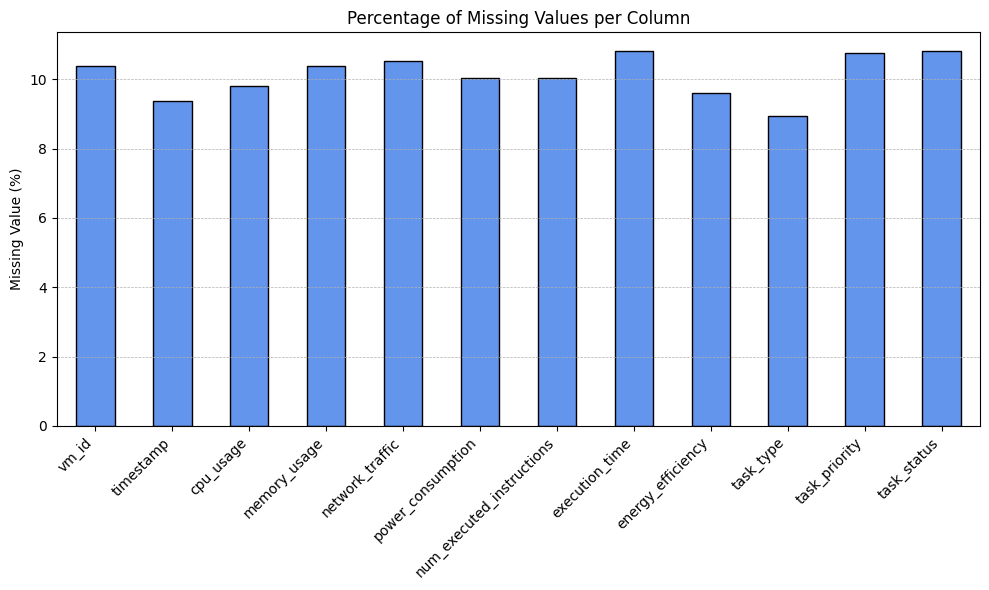

In [7]:
# Calculate percentage of missing values
missing_percent = df.isnull().mean() * 100

# Plot missing percentages
plt.figure(figsize=(10, 6))
missing_percent.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Percentage of Missing Values per Column")
plt.ylabel("Missing Value (%)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [8]:
# Total number of rows
total_rows = len(df)

# Rows with at least one missing value
rows_with_missing = df.isnull().any(axis=1).sum()

# Print results
print(f"Total rows: {total_rows}")
print(f"Rows with at least one missing value: {rows_with_missing}")
print(f"Percentage with missing: {rows_with_missing / total_rows * 100:.2f}%")

Total rows: 2081
Rows with at least one missing value: 1492
Percentage with missing: 71.70%


### Observation
- From the above we know that:
  - There are about 10% of data on each column which we need to take further action on.
  - There are about 70% of the rows has at least one missing data. We cannot drop rows with missing data as it will have sigificant impact to data. We can consider Imputation (e.g., mean/median for numeric, mode or "unknown" for categorical) is a more suitable approach to handle the missing values.
  - Given:
    - Total rows: 2081
    - Rows with at least one missing value: 1492
    - Percentage of affected rows: 71.70%
    - Missing values per column: ~9–11%
  - We should <b>impute with median</b> because:
    - Unsupervised learning requires complete feature vectors
    - Dropping rows isn't viable given that removing 71% of the dataset would result in severe data loss, undermining model generalizability.
    - Median is robust as compared to mean. The median is less sensitive to outliers and is a good choice for skewed or noisy telemetry features.
    - Preserves data size and distribution. Median imputation will retain most of the statistical properties and help preserve the distributions needed for anomaly detection.    

In [9]:
# Display summary statistics for numeric columns in GitHub-style markdown table
print(tabulate(df.describe(), headers='keys', tablefmt='github'))



|       |    cpu_usage |   memory_usage |   network_traffic |   power_consumption |   num_executed_instructions |   execution_time |   energy_efficiency |
|-------|--------------|----------------|-------------------|---------------------|-----------------------------|------------------|---------------------|
| count | 1877         |   1865         |        1862       |         1872        |                     1872    |    1856          |      1881           |
| mean  |   49.9611    |     49.4523    |         499.821   |          253.896    |                     4979.15 |      50.0836     |         0.5031      |
| std   |   29.3547    |     28.7676    |         285.983   |          142.82     |                     2892.39 |      28.4337     |         0.295109    |
| min   |    0.0367344 |      0.0230147 |           1.12517 |            0.170493 |                        3    |       0.00265404 |         0.000329933 |
| 25%   |   24.942     |     24.7701    |         253.167   |         

### Observation
- From the above we know that 
  - Balanced Mean and Median (50% Quantile)
    - For all features, the mean and median (50%) are very close, e.g.:
      - cpu_usage: mean ≈ 49.96, median ≈ 48.97
      - energy_efficiency: mean ≈ 0.5031, median ≈ 0.5047<br>
    - This indicates symmetric or near-normal distributions, which aligns with earlier histograms and low skew values.
  - Wide Range of Values
    - Each metric spans a large range, e.g.:
      - cpu_usage: from ~0 to ~100
      - network_traffic: from ~1 to ~999
      - num_executed_instructions: from 3 to 9999
    - This shows rich variance, useful for distinguishing patterns in unsupervised models.
  - Presence of Low Minimum Values
    - Many features have extremely small minimum values, e.g.:
      - execution_time: min ≈ 0.0027
      - num_executed_instructions: min = 3
    - These may represent edge cases or low-load periods — important for anomaly detection.
  - Consistent Spread Across Features
    - Standard deviations are roughly 30%–60% of the mean, suggesting healthy dispersion without extreme variability.

### Conclusion
  - The data is well-behaved and statistically balanced, with no apparent need for transformation.
  - These properties make it highly suitable for models like Isolation Forest, which perform better when features are evenly distributed and not overly skewed.
  - Outlier or anomaly detection is feasible due to wide ranges and natural variance in all metrics.

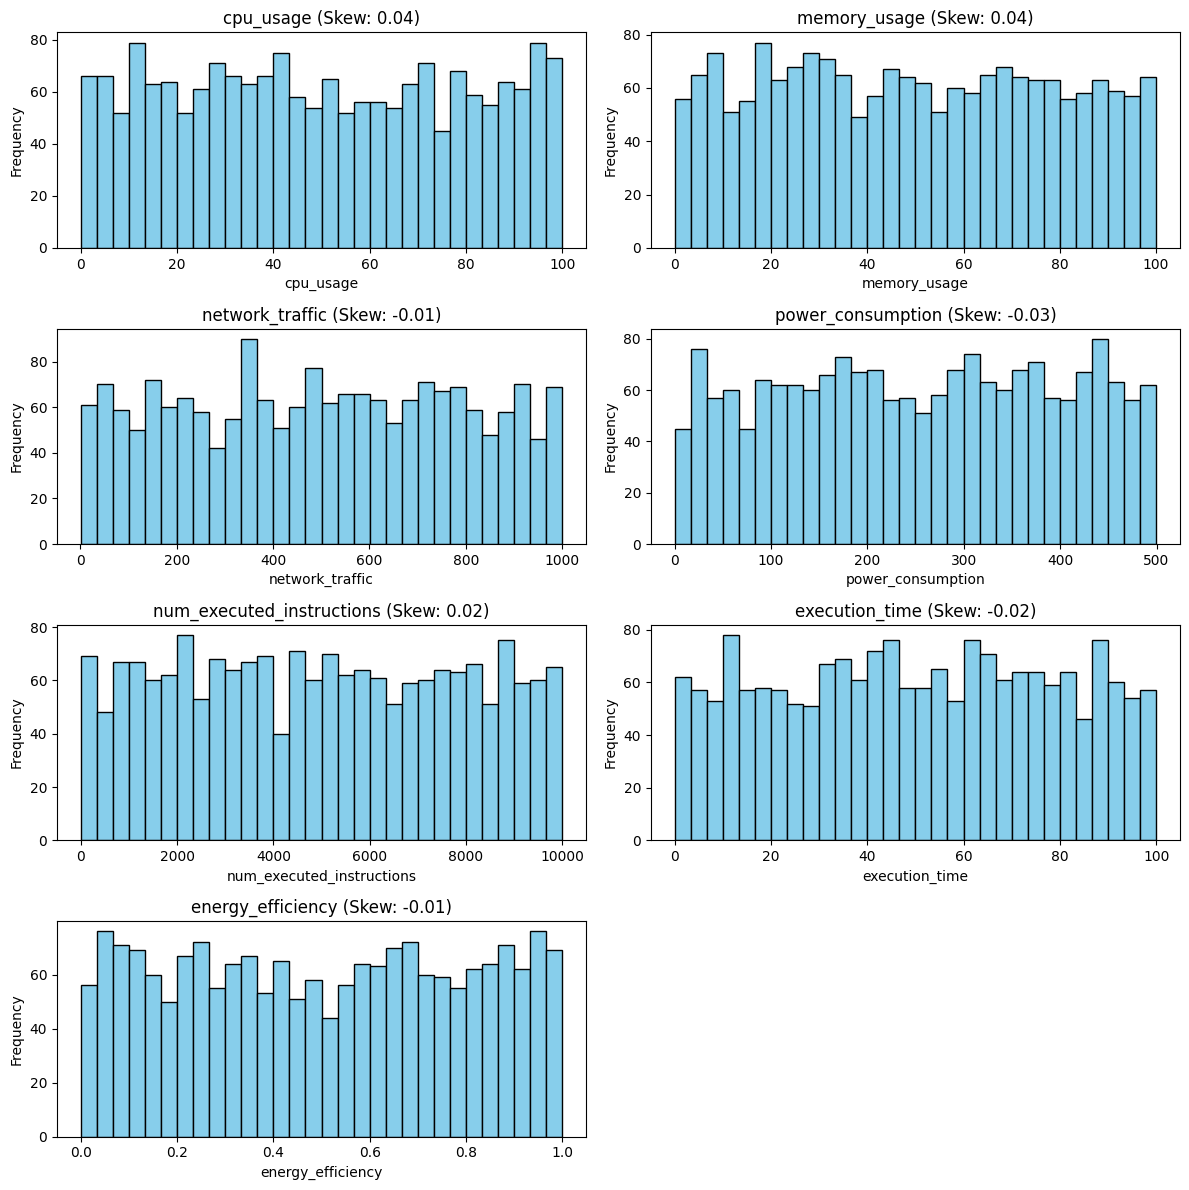

In [10]:
# Define telemetry features to visualize their distributions
# List of numeric columns to plot
columns_to_plot = [
    "cpu_usage", "memory_usage", "network_traffic", "power_consumption",
    "num_executed_instructions", "execution_time", "energy_efficiency"
]
# Create 4x2 subplots (7 plots + 1 unused)
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

# Plot histograms with skewness
for i, col in enumerate(columns_to_plot):
    data = df[col].dropna()
    skew_val = skew(data)

    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f"{col} (Skew: {skew_val:.2f})")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Hide the last unused subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Observation
- All Distributions Are Nearly Symmetric
  - Each numeric feature (e.g., cpu_usage, network_traffic, energy_efficiency) has a skew value close to 0 (between -0.03 and 0.02).
  - This indicates the distributions are approximately uniform or symmetric, with no major bias toward left or right tails.
- No Transformation Required
  - Due to near-zero skew, log, square root, or Box-Cox transformations are not necessary.
  - This saves preprocessing effort and helps maintain interpretability.
- Flat and Evenly Spread Distributions
  - Most histograms show a wide and flat spread, which is ideal for unsupervised anomaly detection models like Isolation Forest, which rely on feature variance.

### Conclusion
- The numeric telemetry features are statistically healthy and well-distributed, making them model-ready without significant preprocessing. Their uniform nature enhances the effectiveness of unsupervised models in detecting anomalies or irregularities.


Based on the above analysis of distributions and skewness:
- Numeric columns will be imputed using the median, as they are symmetrically distributed and the median is robust to outliers.
- Non-numeric (categorical) columns will be imputed with the placeholder 'unknown' to preserve the row and allow downstream encoding without introducing bias.
- `task_type`, `task_priority`, and `task_status` are true categorical features with a small set of discrete values.
- `vm_id` is likely an identifier and therefore not a meaningful category. To be dropped.
- `timestamp` is a datetime-like feature,

In [11]:
df.head()

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,1/25/2023 9:10,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,1/26/2023 4:46,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,1/13/2023 23:39,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2/9/2023 11:45,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,6/14/2023 8:27,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting


In [12]:
# Imputation of missing value of numeric column with median
for col in columns_to_plot:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# vm_id dropped
if "vm_id" in df.columns:
    df.drop(columns=["vm_id"], inplace=True)

# Encode the ordinal 'task_priority' column with numerical values:
# 'low' → 1, 'medium' → 2, 'high' → 3
# Missing or unrecognized values are filled with 0
priority_map = {"low": 1, "medium": 2, "high": 3}
df["task_priority_encoded"] = df["task_priority"].map(priority_map).fillna(0)

# task_priority dropped
if "task_priority" in df.columns:
    df.drop(columns=["task_priority"], inplace=True)

# Encode the ordinal 'task_status' column with numerical values:
# 'waiting' → 1, 'running' → 2, 'completed' → 3
# Fill missing or unrecognized entries with 0
status_map = {"waiting": 1, "running": 2, "completed": 3}
df["task_status_encoded"] = df["task_status"].map(status_map).fillna(0)

# task_status dropped
if "task_status" in df.columns:
    df.drop(columns=["task_status"], inplace=True)

# Perform one-hot encoding on the nominal 'task_type' column.
# Each unique task type (e.g., 'io', 'compute', 'network') becomes its own binary column.
# `dummy_na=True` adds a separate column to indicate missing values.
df = pd.get_dummies(df, columns=["task_type"], dummy_na=True)

# task_type dropped
if "task_type" in df.columns:
    df.drop(columns=["task_type"], inplace=True)

# Change timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")



## Feature Engineering

In [13]:
# Extract datetime components into new columns
df["day"] = df["timestamp"].dt.day
df["month"] = df["timestamp"].dt.month
df["year"] = df["timestamp"].dt.year
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek  # 0 = Monday, 6 = Sunday


# timestamp dropped
if "timestamp" in df.columns:
    df.drop(columns=["timestamp"], inplace=True)

In [15]:
# Verification of column and data type after imputation and encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cpu_usage                  2081 non-null   float64
 1   memory_usage               2081 non-null   float64
 2   network_traffic            2081 non-null   float64
 3   power_consumption          2081 non-null   float64
 4   num_executed_instructions  2081 non-null   float64
 5   execution_time             2081 non-null   float64
 6   energy_efficiency          2081 non-null   float64
 7   task_priority_encoded      2081 non-null   float64
 8   task_status_encoded        2081 non-null   float64
 9   task_type_compute          2081 non-null   bool   
 10  task_type_io               2081 non-null   bool   
 11  task_type_network          2081 non-null   bool   
 12  task_type_nan              2081 non-null   bool   
 13  day                        1886 non-null   float

### Observation
- All columns are numeric and ready for further analysis

SyntaxError: invalid syntax (2999143993.py, line 2)